In [1]:
cd /mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks

/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks


In [2]:
from datetime import datetime
now = datetime.now;t0 = now()
print(now())

2022-01-24 14:59:23.501166


In [3]:
pwd

'/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks'

In [4]:
%time
import numpy as np
import pandas as pd
import ants
import os
from matplotlib import pyplot as plt

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 µs


In [5]:
data_latent_vec = np.load('../Data/latent_vecs.npz')
list(data_latent_vec.keys())

['salient_vec_abide',
 'background_vec_abide',
 'vae_vec_abide',
 'salient_vec_sfari',
 'background_vec_sfari',
 'vae_vec_sfari']

In [6]:
from importlib import reload
import pickle
import helper_funcs;reload(helper_funcs);from helper_funcs import *
import make_models2;reload(make_models2);from make_models2 import *

## LOAD MODEL

In [7]:
%time 
# LOAD CVAE
latent_dim = 16;batch_size = 32;beta = 1;gamma = 100;disentangle = True
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
loss = list()    

fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Feb23_1551_D16B1G100_DTrue'

loss = pickle.load(open(fn+'_loss.pickle','rb'))
cvae.load_weights(fn)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.29 µs

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x1553280f9760> and <tensorflow.python.keras.layers.core.TFOpLambda object at 0x1553300676d0>).


## LOAD DATA

In [8]:
df = pd.read_csv('../Data/ABIDE_legend_S982.csv')
data = np.load('../Data/ABIDE-Anat-64iso-S982.npz')['data']
print(df.shape)
print(data.shape)

(982, 90)
(982, 64, 64, 64)


In [9]:
df.head()

,Unnamed: 0,index,BIDS_ID,Anonymized ID,Subject Type,Visit,Days since enrollment,SubID,DxGroup,DSMIVTR,...,WISC4 Sym Scaled,Age at MPRAGE,Current Med Status,Medication Name,Medication Name.1,Off stimulants at EPI scan?,ScanSite,ScannerType,ScannerID,ScanSiteID
0,0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
1,1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
2,2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
3,3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
4,4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3


In [10]:
%time
z_embed = z_encoder.predict(data)[2]
s_embed = s_encoder.predict(data)[2]
print(s_embed.shape)

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 14.8 µs
(982, 16)


In [11]:
latents = pickle.load(open('../Data/embedded_data.pickle','rb'))
list(latents.keys())

['embedding_bg',
 'embedding_sl',
 'embedding_vae',
 'sfari_embedding_vae',
 'sfari_embedding_bg',
 'sfari_embedding_sl',
 'bg_space_abide',
 'sl_space_abide',
 'vae_space_abide',
 'bg_space_sfari',
 'sl_space_sfari',
 'vae_space_sfari',
 'bg_Sspace_sfari',
 'sl_Sspace_sfari',
 'vae_Sspace_sfari',
 'reducer_bg_abide',
 'reducer_sl_abide',
 'reducer_vae_abide',
 'reducer_bg_sfari',
 'reducer_sl_sfari',
 'reducer_vae_sfari']

In [12]:
latents['embedding_sl'].shape

(470, 16)

In [13]:
umap_sl = latents['reducer_sl_abide']

In [14]:
patients = df['DxGroup'].values==1

In [15]:
latents['embedding_sl'].shape

(470, 16)

In [16]:
%%capture
embedding_sl = umap_sl.transform(latents['embedding_sl'])

In [17]:
embedding_sl.shape

(470, 2)

In [18]:
x_loading = embedding_sl[:,0]
y_loading = embedding_sl[:,1]

Text(0.5, 1.0, 'SL SPACE')

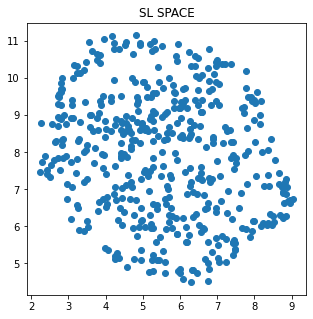

In [19]:
plt.figure(figsize=(5,5))
plt.scatter(embedding_sl[:,0],embedding_sl[:,1])
#plt.scatter(embedding_sl[x_bot_50,0],embedding_sl[x_bot_50,1])
plt.title('SL SPACE')

In [20]:
keys = ['ADOS_Total','ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh']
for key in keys:
    vec = df[key].values[patients]
    e = np.isnan(vec)
    r_x = np.corrcoef(vec[~e],x_loading[~e])[0,1]
    r_y = np.corrcoef(vec[~e],y_loading[~e])[0,1]
    print(f'{key} | X:{r_x:.2f},Y:{r_y:.2f}')

ADOS_Total | X:-0.06,Y:-0.05
ADOS_Comm | X:-0.08,Y:0.02
ADOS_Social | X:-0.04,Y:-0.07
ADOS_StBeh | X:-0.14,Y:0.01


ADOS_Total | X:-0.03,Y:-0.12


ADOS_Comm | X:-0.04,Y:-0.07


ADOS_Social | X:-0.02,Y:-0.12


ADOS_StBeh | X:-0.12,Y:-0.06

In [21]:
x_bot_50 = np.argsort(x_loading)[0:50]
x_top_50 = np.argsort(x_loading)[-50::]

y_bot_50 = np.argsort(y_loading)[0:50]
y_top_50 = np.argsort(y_loading)[-50::]

Text(0.5, 1.0, 'SL SPACE')

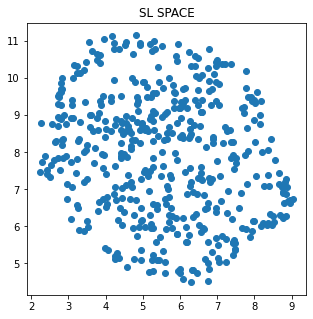

In [22]:
plt.figure(figsize=(5,5))
plt.scatter(embedding_sl[:,0],embedding_sl[:,1])
#plt.scatter(embedding_sl[x_bot_50,0],embedding_sl[x_bot_50,1])
plt.title('SL SPACE')

In [23]:
_max = embedding_sl.max(axis=0)
_min = embedding_sl.min(axis=0)
_mid = embedding_sl.mean(axis=0)

In [24]:
# CALC CORNERS
top = (_mid[0],_max[1])
bottom = (_mid[0],_min[1])
left = (_min[0],_mid[1])
right = (_max[0],_mid[1])

top = np.array(top)
bottom = np.array(bottom)
left = np.array(left)
right = np.array(right)


print(f'top | {top}')
print(f'botom | {bottom}')
print(f'left | {left}')
print(f'right | {right}')

top | [ 5.552891 11.156689]
botom | [5.552891 4.487164]
left | [2.2256591 7.9044423]
right | [9.042705  7.9044423]


In [25]:
idx_top50 = np.argsort(np.linalg.norm(embedding_sl-top,axis=1))[0:50]
idx_bottom50 = np.argsort(np.linalg.norm(embedding_sl-bottom,axis=1))[0:50]

idx_left50 = np.argsort(np.linalg.norm(embedding_sl-left,axis=1))[0:50]
idx_right50 = np.argsort(np.linalg.norm(embedding_sl-right,axis=1))[0:50]

Text(0.5, 1.0, 'SL SPACE')

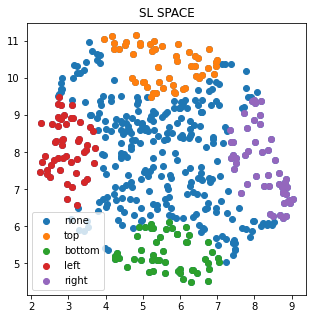

In [26]:
plt.figure(figsize=(5,5))
plt.scatter(embedding_sl[:,0],embedding_sl[:,1])
plt.scatter(embedding_sl[idx_top50,0],embedding_sl[idx_top50,1])
plt.scatter(embedding_sl[idx_bottom50,0],embedding_sl[idx_bottom50,1])
plt.scatter(embedding_sl[idx_left50,0],embedding_sl[idx_left50,1])
plt.scatter(embedding_sl[idx_right50,0],embedding_sl[idx_right50,1])
plt.legend(['none','top','bottom','left','right'])
plt.title('SL SPACE')

In [27]:
def get_corner_brains(invec):
    z = z_encoder.predict(data[patients,:,:,:][invec,:,:,:])[2]
    s = s_encoder.predict(data[patients,:,:,:][invec,:,:,:])[2]
    zeros = np.zeros(s.shape)

    recon = cvae_decoder.predict(np.hstack((z,s)))[:,:,:,:,0]
    twin = cvae_decoder.predict(np.hstack((z,zeros)))[:,:,:,:,0]

    return recon,twin

In [29]:
#interp_type = 1 # linear
interp_type = 4 # bSpline
im = ants.image_read('../Data/anat_temp.nii')
im = im.resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=interp_type)

In [30]:
template = ants.image_read('../Data/Atlas_brain_2mm.nii')
template = template.resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=interp_type)
template_o = template.copy()
template = ants.iMath_normalize(template)

In [31]:
df_asd = df.iloc[patients]

In [32]:
#n = recon.shape[0]
# invec = idx_top50
# recon,twin = get_corner_brains(invec)
# brains_recon = [im.new_image_like(recon[i,:,:,:]) for i in range(n)]
# brains_twin = [im.new_image_like(twin[i,:,:,:]) for i in range(n)]

In [33]:
## NEW

In [34]:
def get_Js(invec):
    from tqdm import tqdm
    tmp_dir = '/scratch/aglinska/ants_files/'
    
    interpolator = 'bSpline'
    interp_type=4
    
    Js,normed_t1s,normed_recons,normed_twins,nativeJs = [],[],[],[],[]
    recon,twin = get_corner_brains(invec)
    
    for i in tqdm(range(len(invec))):
        sub = df['BIDS_ID'].values[patients][invec[i]]
        
        t1 = ants.image_read(f'../../data/fMRI_InData/abide_bids/{sub}/anat/{sub}_brain.nii')
        t1 = t1.resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=interp_type)
        t1 = ants.iMath_normalize(t1)
        
        
        recon_mat = recon[i,:,:,:]
        twin_mat = twin[i,:,:,:]
        
        recon_brain = t1.new_image_like(recon_mat)
        twin_brain = t1.new_image_like(twin_mat)
        
        twin_brain = ants.iMath_normalize(twin_brain)
        recon_brain = ants.iMath_normalize(recon_brain)
        
        #twin_brain = ants.registration(fixed=t1,moving=twin_brain,type_of_transform='Rigid')['warpedmovout']
        #recon_brain = ants.registration(fixed=t1,moving=recon_brain,type_of_transform='Rigid')['warpedmovout']
        
        #rtx2t = ants.registration(fixed=template,moving=twin_brain,type_of_transform='Rigid')['warpedmovout']
        
        
        tx = ants.registration(fixed=twin_brain,moving=recon_brain,type_of_transform='SyN',outprefix=tmp_dir)
        J = ants.create_jacobian_determinant_image(domain_image=twin_brain,tx=tx['fwdtransforms'][0])
        J = J-1

        norm = ants.registration(fixed=template,moving=t1,type_of_transform='SyN',outprefix=tmp_dir)
        normed_t1 = ants.apply_transforms(fixed=template,moving=t1,transformlist=norm['fwdtransforms'],interpolator=interpolator)
        
        normed_recon = ants.apply_transforms(fixed=template,moving=recon_brain,transformlist=norm['fwdtransforms'],interpolator=interpolator)
        normed_twin = ants.apply_transforms(fixed=template,moving=twin_brain,transformlist=norm['fwdtransforms'],interpolator=interpolator)
        normed_J = ants.apply_transforms(fixed=template,moving=J,transformlist=norm['fwdtransforms'],interpolator=interpolator)
        
        normed_J[template_o<100]=0

        Js.append(normed_J)
        normed_t1s.append(normed_t1)
        normed_recons.append(normed_recon)
        normed_twins.append(normed_twin)
        nativeJs.append(J)

    res = dict()
    res['Js'] = Js
    res['native_Js'] = nativeJs
    res['normed_t1s'] = normed_t1s
    res['normed_recons'] = normed_recons
    res['normed_twins'] = normed_twins
    res['twin_brain'] = twin_brain 
    res['recon_brain'] = recon_brain
    res['t1'] = t1
#     res[''] = 
#     res[''] = 
#     res[''] = 
    
    return res

In [37]:
%%time
res_top = get_Js(idx_top50)
res_bottom = get_Js(idx_bottom50)
res_left = get_Js(idx_left50)
res_right = get_Js(idx_right50)

100%|██████████| 50/50 [04:29<00:00,  5.40s/it]

CPU times: user 1h 33min 39s, sys: 5min 52s, total: 1h 39min 31s
Wall time: 19min


In [42]:
list(res_top.keys())

['Js',
 'native_Js',
 'normed_t1s',
 'normed_recons',
 'normed_twins',
 'twin_brain',
 'recon_brain',
 't1']

In [43]:
# for i in range(50):
#     res_top['Js'][i][template<100]=0
#     res_bottom['Js'][i][template<100]=0
#     res_left['Js'][i][template<100]=0
#     res_right['Js'][i][template<100]=0

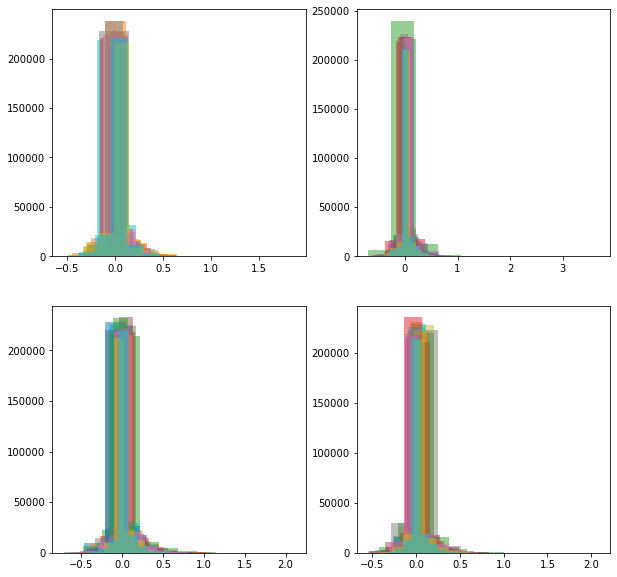

In [44]:
fig, axs = plt.subplots(2,2,figsize=(10,10))

plt.subplot(2,2,1);
[plt.hist(res_top['Js'][i].numpy()[template.numpy()>0],alpha=.5) for i in range(50)];

plt.subplot(2,2,2);
[plt.hist(res_bottom['Js'][i].numpy()[template.numpy()>0],alpha=.5) for i in range(50)];

plt.subplot(2,2,3);
[plt.hist(res_left['Js'][i].numpy()[template.numpy()>0],alpha=.5) for i in range(50)];

plt.subplot(2,2,4);
[plt.hist(res_right['Js'][i].numpy()[template.numpy()>0],alpha=.5) for i in range(50)];

In [45]:
# dump results
[res_top['Js'][i].to_filename(f'~/corner_Js/top_{i:02d}.nii') for i in range(50)];
[res_bottom['Js'][i].to_filename(f'~/corner_Js/bottom_{i:02d}.nii') for i in range(50)];
[res_left['Js'][i].to_filename(f'~/corner_Js/left_{i:02d}.nii') for i in range(50)];
[res_right['Js'][i].to_filename(f'~/corner_Js/right_{i:02d}.nii') for i in range(50)];

In [46]:
!zip -r -q ~/corner_Js.zip ~/corner_Js

In [47]:
# [res_top['Js'][i].to_filename(f'~/corner_ims/normed_t1s{i:02d}.nii') for i in range(50)];
# [res_bottom['Js'][i].to_filename(f'~/corner_ims/normed_t1s{i:02d}.nii') for i in range(50)];
# [res_left['Js'][i].to_filename(f'~/corner_ims/normed_t1s{i:02d}.nii') for i in range(50)];
# [res_right['Js'][i].to_filename(f'~/corner_ims/normed_t1s{i:02d}.nii') for i in range(50)];

# [res_top['Js'][i].to_filename(f'~/corner_ims/normed_recons{i:02d}.nii') for i in range(50)];
# [res_bottom['Js'][i].to_filename(f'~/corner_ims/normed_recons{i:02d}.nii') for i in range(50)];
# [res_left['Js'][i].to_filename(f'~/corner_ims/normed_recons{i:02d}.nii') for i in range(50)];
# [res_right['Js'][i].to_filename(f'~/corner_ims/normed_recons{i:02d}.nii') for i in range(50)];

# [res_top['Js'][i].to_filename(f'~/corner_ims/normed_twins{i:02d}.nii') for i in range(50)];
# [res_bottom['Js'][i].to_filename(f'~/corner_ims/normed_twins{i:02d}.nii') for i in range(50)];
# [res_left['Js'][i].to_filename(f'~/corner_ims/normed_twins{i:02d}.nii') for i in range(50)];
# [res_right['Js'][i].to_filename(f'~/corner_ims/normed_twins{i:02d}.nii') for i in range(50)];

In [48]:
# !zip -r -q ~/corner_ims.zip ~/corner_ims

In [49]:
cd ~/corner_Js/

/mmfs1/data/aglinska/corner_Js


In [50]:
def glm_2nd_lvl_t(second_level_input,con_name='tCon',threshold=2.5):
    
    nsubs = int(len(second_level_input)/2)
    condition_effect = np.hstack((np.repeat(1,nsubs),np.repeat(-1,nsubs)))

    # subject_effect = np.eye(n_subjects)
    # subjects = [f'S{i:02d}' for i in range(1, n_subjects + 1)]

    unpaired_design_matrix = pd.DataFrame(
        condition_effect[:, np.newaxis],
        columns=[con_name])

    from nilearn.glm.second_level import SecondLevelModel
    from nilearn import plotting

    second_level_model_unpaired = SecondLevelModel().fit(
        second_level_input, design_matrix=unpaired_design_matrix)

    # second_level_model_paired = SecondLevelModel().fit(
    #     second_level_input, design_matrix=paired_design_matrix)

    stat_maps_unpaired = second_level_model_unpaired.compute_contrast(con_name,output_type='all')
    
    return stat_maps_unpaired


def plot_2nd_level(stat_maps_unpaired,threshold=3.1,con_name='tCon'):
    #threshold = 2.5  # corresponds to  p < .001, uncorrected
    display = plotting.plot_glass_brain(
    stat_maps_unpaired['z_score'], threshold=threshold, colorbar=True, plot_abs=False,
    title=f'{con_name} t>{threshold}', vmin=0, vmax=6)

In [51]:
%%time
group1 = [file for file in os.listdir() if 'left' in file];group1.sort()
group2 = [file for file in os.listdir() if 'right' in file];group2.sort()
second_level_input = group1+group2
res_LR = glm_2nd_lvl_t(second_level_input)

group1 = [file for file in os.listdir() if 'top' in file];group1.sort()
group2 = [file for file in os.listdir() if 'bottom' in file];group2.sort()
second_level_input = group1+group2
res_TB = glm_2nd_lvl_t(second_level_input)

n_subjects = len(second_level_input)
print(n_subjects)

/data/aglinska/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning:

The nilearn.glm module is experimental. It may change in any future release of Nilearn.



100
CPU times: user 55.1 s, sys: 10.1 s, total: 1min 5s
Wall time: 49.4 s


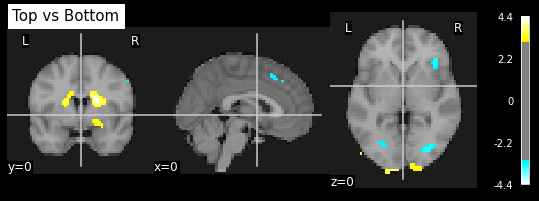

In [62]:
from nilearn import plotting
bg_img=template.to_nibabel()
stat_map_img = res_TB['z_score']
threshold = 3.1
title = 'Top vs Bottom'
plotting.plot_stat_map(stat_map_img=stat_map_img,bg_img=bg_img,threshold=threshold,title=title,cut_coords=(0,0,0))

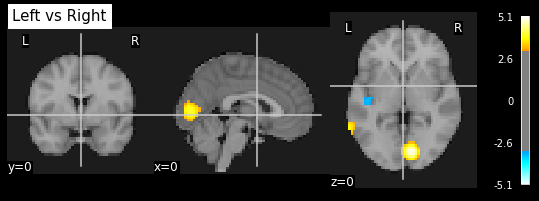

In [63]:
bg_img=template.to_nibabel()
stat_map_img = res_LR['z_score']
threshold = 3.1
title = 'Left vs Right'
plotting.plot_stat_map(stat_map_img=stat_map_img,
                       bg_img=bg_img,
                       threshold=threshold,
                       title=title,cut_coords=(0,0,0))

In [54]:
bg_img.to_filename('../bg_img.nii')

In [55]:
res_LR['z_score'].to_filename('../LR_zmap.nii')
res_TB['z_score'].to_filename('../TB_zmap.nii')

In [56]:
# res_LR['z_score'].to_filename('res_LR.nii')
# res_TB['z_score'].to_filename('res_TB.nii')
# template.to_filename('template.nii')

In [57]:
print(now())
print(now()-t0)

2022-01-24 15:49:13.848451
0:49:50.347390
